In [3]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV

# clasification algorithms
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.svm import SVC

from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV


# model seralization
import pickle


### Declaración de constantes y funciones

In [4]:
# Constantes

# DATASET_PATH = "../data/CARTONES/data_transformed_target.csv"
DATASET_PATH = "../data/CARTONES/data_transformed_target_con_devoluciones.csv"

DATASET_ENCODING = "UTF-8"
DATASET_COLUMN_SEPARATOR = ","

ALL_COLUMNS = ['N° Factura','SKU','Kilos','USD TC Prom.Mes','Condición de pago','Devoluciones', 'USD/Ton',
        'Kilos_Promedio', 'Kilos_Maximo','Kilos_Minimo', 'Frecuencia',
        'Indice devoluciones', 'Buenos Aires', 'Catamarca', 'Chaco', 'Chubut',
        'Corrientes', 'Córdoba', 'Entre Rios', 'Exportación', 'Formosa',
        'Jujuy', 'La Pampa', 'La Rioja', 'Mendoza', 'Misiones', 'Neuquén',
        'Rio Negro', 'Salta', 'San Juan', 'San Luis', 'Santa Cruz', 'Santa Fe',
        'Santiago del Estero', 'Tierra del Fuego', 'Tucumán', 'Alimentos',
        'Bebidas', 'Carne y productos carnicos', 'Construccion',
        'Cuidado Salud, Cosm. y Farmac.', 'Electronica, electricos hogar',
        'Golosinas', 'Madera y muebles', 'Metalurgica',
        'Prod plast/vidrio/metal/caucho', 'Productos Lacteos',
        'Productos agricolas y frescos', 'Productos de tabaco',
        'Productos limpieza del hogar', 'Productos papel y relacionados',
        'Productos quimicos y afines', 'Servicios',
        'Textiles/prendas vestir/cuero','Target']

CATEGORICAL_COLUMNS = ['Buenos Aires', 'Catamarca', 'Chaco', 'Chubut',
        'Corrientes', 'Córdoba', 'Entre Rios', 'Exportación', 'Formosa',
        'Jujuy', 'La Pampa', 'La Rioja', 'Mendoza', 'Misiones', 'Neuquén',
        'Rio Negro', 'Salta', 'San Juan', 'San Luis', 'Santa Cruz', 'Santa Fe',
        'Santiago del Estero', 'Tierra del Fuego', 'Tucumán', 'Alimentos',
        'Bebidas', 'Carne y productos carnicos', 'Construccion',
        'Cuidado Salud, Cosm. y Farmac.', 'Electronica, electricos hogar',
        'Golosinas', 'Madera y muebles', 'Metalurgica',
        'Prod plast/vidrio/metal/caucho', 'Productos Lacteos',
        'Productos agricolas y frescos', 'Productos de tabaco',
        'Productos limpieza del hogar', 'Productos papel y relacionados',
        'Productos quimicos y afines', 'Servicios',
        'Textiles/prendas vestir/cuero']

TARGET_COLUMN = ['Target']

NUMERIC_COLUMNS = list(set(ALL_COLUMNS) - set(CATEGORICAL_COLUMNS) - set(TARGET_COLUMN))

In [5]:
def get_dataset():
    """
    Lee el dataset que se usará para el entrenamiento del modelo.
    """
    df = pd.read_csv(DATASET_PATH, encoding=DATASET_ENCODING, sep=DATASET_COLUMN_SEPARATOR)
    return df

In [6]:
def selecting_features(df):
    """
    Selecciona las features que serán usadas en el modelo.
    """
    df = df[ALL_COLUMNS]
    return df

In [7]:
def encoding_categoric_features(df):
    """
    Realiza el encoding de las features categóricas.
    """
    return pd.get_dummies(df, columns=CATEGORICAL_COLUMNS, drop_first=True)

In [8]:
def spliting_dataset(df):
    """
    Separa los datasets de entrenamiento y prueba. 
    """
    X_train, X_test, y_train, y_test = train_test_split(df.drop(TARGET_COLUMN, axis=1), df[TARGET_COLUMN], test_size=0.3, random_state=0)
    return X_train, X_test, y_train, y_test

In [9]:
def scaling_numeric_features(X_train, X_test, y_train, y_test):    
    """
    Realiza el escalamiento de las variables numéricas en la data de entrenamiento.
    """

    # split numeric and categorical features
    X_train_num = X_train[NUMERIC_COLUMNS]
    X_test_num = X_test[NUMERIC_COLUMNS]

    X_train_dum= X_train.drop(NUMERIC_COLUMNS, axis=1)
    X_test_dum = X_test.drop(NUMERIC_COLUMNS, axis=1)

    # set up a standard scaler transformer using StandardScaler() from scikit-learn
    scaler = StandardScaler()
    scaler.fit(X_train_num)

    # Now, let's standardize the train and test sets with the trained scaler
    X_train_num_scaled = scaler.transform(X_train_num)
    X_test_num_scaled = scaler.transform(X_test_num)

    # Scikit-learn scalers, just like any scikit-learn transformer, return NumPy
    # arrays. To convert the array into a dataframe
    X_train_num_scaled = pd.DataFrame(X_train_num_scaled, columns=X_train_num.columns)
    X_test_num_scaled = pd.DataFrame(X_test_num_scaled, columns=X_test_num.columns)
    
    # reset index
    X_train_dum.reset_index(drop=True, inplace=True)
    X_test_dum.reset_index(drop=True, inplace=True)

    y_train.reset_index(drop=True, inplace=True)
    y_train = y_train[TARGET_COLUMN[0]].values
    
    y_test.reset_index(drop=True, inplace=True)
    y_test = y_test[TARGET_COLUMN[0]].values

    # Concat dataframes numeric scaled and dummies 
    X_train_final = pd.concat([X_train_num_scaled, X_train_dum], axis=1)
    X_test_final = pd.concat([X_test_num_scaled, X_test_dum], axis=1)

    return X_train_final, X_test_final, y_train, y_test
    

In [10]:
def show_target_balance(y_train):
    """
    Muestra el el balanceo de la target en la data de entrenamiento 
    """
    y_train_df = pd.Series(y_train)
    v_0 = y_train_df.value_counts()[0]
    v_1 = y_train_df.value_counts()[1]
    print('total : ', y_train_df.shape[0])
    print('  v_0 : ', v_0)
    print('  v_1 :  ', v_1)
    print('ratio : ', v_1/(v_0 + v_1)*100)


In [11]:
def balancing_target(X_train, y_train, f=0.8):
    """
    Realiza el balanceo de la target en la data de entrenamiento 
    """    
    df_X_train = pd.DataFrame(X_train, columns=X_train.columns)
    df_y_train = pd.DataFrame(y_train, columns=TARGET_COLUMN)
    df_train = pd.concat([df_X_train, df_y_train], axis=1)

    data_0 = df_train[df_train[TARGET_COLUMN[0]]==0].sample(frac=f, random_state=12)
    data_1 = df_train[df_train[TARGET_COLUMN[0]]==1]

    data_balanceada = pd.concat([data_0, data_1], axis=0)
    
    X_train_bal = data_balanceada.drop(TARGET_COLUMN, axis=1)
    y_train_bal = data_balanceada[TARGET_COLUMN[0]].values

    return X_train_bal, y_train_bal

In [12]:
def confusion_matrix_visual(y_true, y_pred, class_labels, ax=None, title=None, **kwargs):
    """
    Muestra gráficamente la matriz de confusión.
    """
    mat = confusion_matrix(y_true, y_pred)
    axes = sns.heatmap(
    mat.T, square=True, annot=True, fmt='d',
    cbar=True, cmap=plt.cm.Blues, ax=ax, **kwargs
    )
    axes.set_xlabel('Actual')
    axes.set_ylabel('Model Prediction')
    tick_marks = np.arange(len(class_labels)) + 0.5
    axes.set_xticks(tick_marks)
    axes.set_xticklabels(class_labels)
    axes.set_yticks(tick_marks)
    axes.set_yticklabels(class_labels, rotation=0)
    axes.set_title(title or 'Confusion Matrix')
    return axes


In [13]:
def feature_importance_visual(trained_model, X_train):
    """
    Muestra gráficamente las 7 features más importantes
    """
    plt.figure(figsize=(10,7))
    feat_importances = pd.Series(trained_model.best_estimator_.feature_importances_, index = X_train.columns)
    feat_importances.nlargest(7).plot(kind='barh');

In [14]:
def model_dump(filename, model):
    """
    Serializa un modelo y lo guarda como un fichero .pkl
    """
    # dump the model to disk
    pickle.dump(model, open(filename, 'wb'))

In [15]:
def model_load(filename):
    """
    Carga un modelo serializado a partir de un archivo .pkl
    """
    # load the model from disk
    return pickle.load(open(filename, 'rb'))

In [42]:
def get_best_hiperparams(model, params, scoring, X_train, y_train):
    rs = RandomizedSearchCV(estimator=model, param_distributions=params, random_state=0)
    search = rs.fit(X_train, y_train)
    print('{} = {}'.format(scoring, search.best_score_))
    print ('Parámetros óptimos: {}'.format(search.best_params_))

## Preparar features y target

In [16]:
def processing():
    df = get_dataset()
    df = selecting_features(df)
    X_train, X_test, y_train, y_test = spliting_dataset(df)
    X_train, X_test, y_train, y_test = scaling_numeric_features(X_train, X_test, y_train, y_test)
    print("Sin balanceo de target:" )
    show_target_balance(y_train)
    return X_train, X_test, y_train, y_test
    
X_train, X_test, y_train, y_test = processing()


Sin balanceo de target:
total :  14608
  v_0 :  13434
  v_1 :   1174
ratio :  8.03669222343921


## Model Training

### 1. XGBClassifier con GridSearchCV

#### Obtener hiperparámetros óptimos

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[15:36:05] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 500}
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      5800
           1       0.84      0.71      0.77       461

    accuracy                           0.97      6261
   macro avg       0.91      0.85      0.88      6261
weighted avg       0.97      0.97      0.97      6261



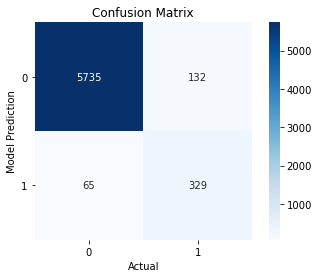

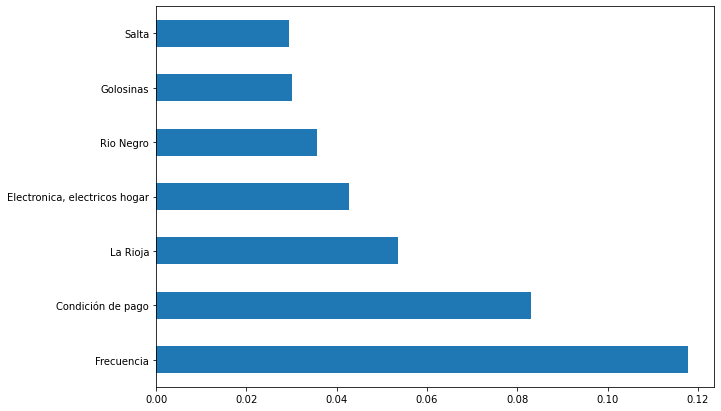

In [45]:
# model_xg = XGBClassifier(n_jobs=-1, use_label_encoder=False)

cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

params = {  
    # "n_estimators": [50,100,500],      # Number of boosted trees to fit.
    "n_estimators": [500, 1000],
    "max_depth": [4,8],            # Maximum tree depth for base learners.
    "learning_rate": [0.01, 0.1],      # Boosting learning rate (xgb’s “eta”)
}

xgb = GridSearchCV(
    XGBClassifier(n_jobs=-1, use_label_encoder=False, random_state=12), 
    param_grid=params, 
    cv=cv, 
    verbose=1, 
    n_jobs=-1)
xgb.fit(X_train,y_train)

best_hyperparams = xgb.best_params_
print(best_hyperparams)

# Show classifier performance 
preds = xgb.predict(X_test)
confusion_matrix_visual(y_test, preds, ['0', '1'])
print(classification_report(y_test, preds))
feature_importance_visual(xgb, X_train)


### 2. GradientBoostingClassifier con GridSearchCV

#### Tunning de hiperparámetros

In [ ]:
estimator = GradientBoostingClassifier()
estimator.get_params().keys()

dict_keys(['ccp_alpha', 'criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'random_state', 'subsample', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

#### Entrenamos el modelo

Fitting 3 folds for each of 36 candidates, totalling 108 fits
{'learning_rate': 0.1, 'max_depth': 8, 'min_samples_leaf': 4, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      5800
           1       0.85      0.60      0.70       461

    accuracy                           0.96      6261
   macro avg       0.91      0.80      0.84      6261
weighted avg       0.96      0.96      0.96      6261



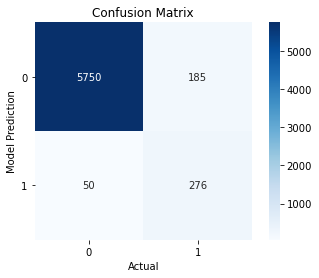

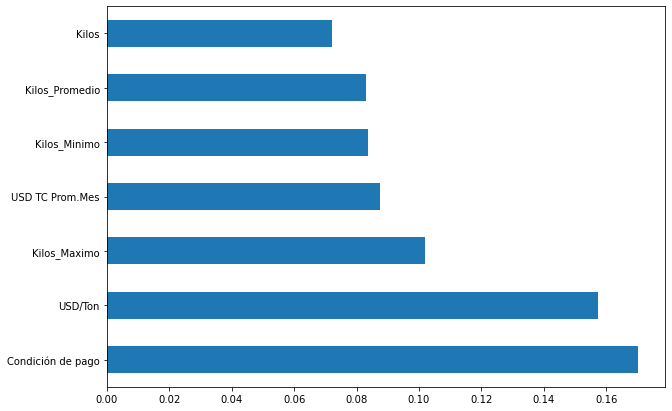

In [ ]:
search_space = {
    "n_estimators": [50,100],
    'max_depth' : [4, 8], # keep trees small to avoid overfitting
    'min_samples_leaf' : [4, 6, 12],
    'learning_rate' : [0.1, 0.5, 1]
}

cv = StratifiedKFold(n_splits=3, random_state=0, shuffle=True)

gb_grid = GridSearchCV(
    GradientBoostingClassifier(), 
    search_space, 
    cv=cv, 
    scoring='precision',
    verbose=1, 
    n_jobs=-1
).fit(X_train, y_train)

best_hyperparams = gb_grid.best_params_
print(best_hyperparams)

# Show classifier performance 
preds = gb_grid.predict(X_test)

confusion_matrix_visual(y_test, preds, ['0', '1'])
print(classification_report(y_test, preds))
feature_importance_visual(gb_grid, X_train)


### 3. BaggingClassifier con GridSearchCV

### Tunning de hiperparámetros

In [ ]:
estimator = tree.DecisionTreeClassifier()
estimator.get_params().keys()

dict_keys(['ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'random_state', 'splitter'])

Fitting 3 folds for each of 24 candidates, totalling 72 fits
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      5800
           1       0.74      0.21      0.33       461

    accuracy                           0.94      6261
   macro avg       0.84      0.60      0.65      6261
weighted avg       0.93      0.94      0.92      6261



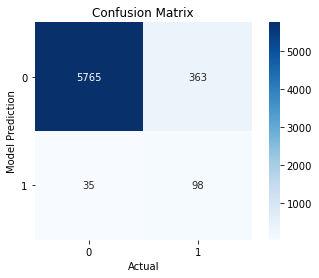

In [41]:
grid_params_bg = {"base_estimator__max_depth": [4,8],
        "base_estimator__min_samples_leaf": [3, 5, 12],
        'bootstrap_features': [False, True],
        'n_estimators': [1000, 2000],
}

cv = StratifiedKFold(n_splits=3, random_state=0, shuffle=True)

grid_bg = GridSearchCV(
        BaggingClassifier(DecisionTreeClassifier()), 
        grid_params_bg, 
        cv=cv, 
        verbose=1,
        n_jobs=-1
        ).fit(X_train, y_train)

# Show classifier performance 
preds = grid_bg.predict(X_test)

confusion_matrix_visual(y_test, preds, ['0', '1'])
print(classification_report(y_test, preds))

# grid_bg.predict_proba(X_test)


### 4. RandomForestClassifier

#### Tunning de hiperparámetros

In [ ]:
params_rfc = {'bootstrap': [True, False],
    'max_depth': [4, 8],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [1000, 2000]}

get_best_hiperparams(model=RandomForestClassifier(),params=params_rfc,scoring='precision', X_train=X_train,y_train=y_train)   

#### Entrenar modelo

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      5800
           1       0.89      0.69      0.77       461

    accuracy                           0.97      6261
   macro avg       0.93      0.84      0.88      6261
weighted avg       0.97      0.97      0.97      6261



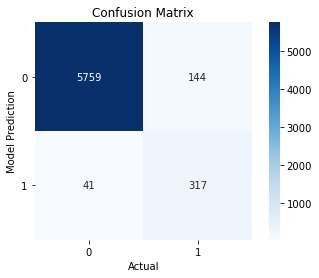

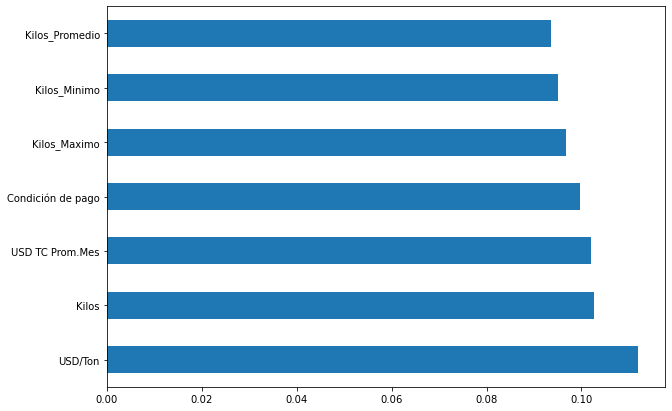

In [24]:
rf_clf = RandomForestClassifier(n_estimators=400, min_samples_split=5, min_samples_leaf= 1, max_features='auto', max_depth=90, bootstrap=False)
rf_clf.fit(X_train, y_train)

# Show classifier performance 
preds = rf_clf.predict(X_test)

confusion_matrix_visual(y_test, preds, ['0', '1'])
print(classification_report(y_test, preds))


# Graficar feature importance
plt.figure(figsize=(10,7))
feat_importances = pd.Series(rf_clf.feature_importances_, index = X_train.columns)
feat_importances.nlargest(7).plot(kind='barh');


### 5. KNeighborsClassifier

#### Obtener los hiperparámetros óptimos

In [ ]:
params_knn = {
        'n_neighbors': range(1,25), 
        'weights' : ['uniform', 'distance']
}

get_best_hiperparams(model=KNeighborsClassifier(),params=params_knn,scoring='precision', X_train=X_train,y_train=y_train)   

precision = 0.9609119311385068
Parámetros óptimos: {'weights': 'distance', 'n_neighbors': 19}


#### Entrenamos el modelo

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      5800
           1       0.88      0.69      0.77       461

    accuracy                           0.97      6261
   macro avg       0.93      0.84      0.88      6261
weighted avg       0.97      0.97      0.97      6261



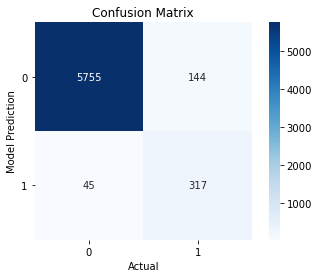

In [26]:

knn = KNeighborsClassifier(
    weights='distance', 
    n_neighbors= 19
).fit(X_train, y_train)

preds = knn.predict(X_test)

confusion_matrix_visual(y_test, preds, ['0', '1'])
print(classification_report(y_test, preds))

### 6. SVC con GridSearchCV

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      5800
           1       0.68      0.57      0.62       461

    accuracy                           0.95      6261
   macro avg       0.82      0.77      0.80      6261
weighted avg       0.94      0.95      0.95      6261



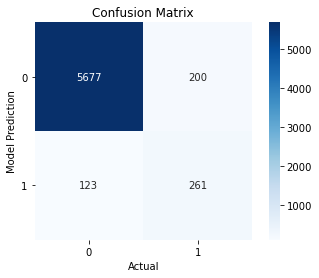

In [40]:
param_svc = {'C': [0.1, 1, 10],
            'gamma': [1, 0.1, 0.01],
            'kernel': ['rbf']
            }
 
cv = StratifiedKFold(n_splits=3, random_state=0, shuffle=True)

grid_svc = GridSearchCV(
                SVC(), 
                param_svc, 
                cv=cv,
                refit = True).fit(X_train, y_train)

# Show classifier performance 
preds = grid_svc.predict(X_test)

confusion_matrix_visual(y_test, preds, ['0', '1'])
print(classification_report(y_test, preds))

## Curva ROC para comparar los modelos

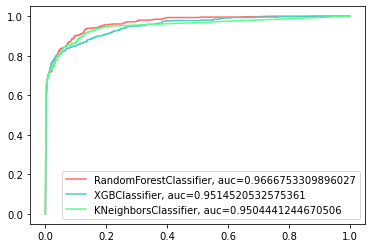

In [51]:
def ROC(models, X_test, y_test, labels):
    """ 
    Grafica la curva para comparar los modelos
    """ 
    fig, ax = plt.subplots()
    colors=['#FF6B6B','#4ECDC4','#5EFC8D','#050505']
    i=0
    for model in models:
        y_pred_proba = model.predict_proba(X_test)[::,1]
        fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
        auc = metrics.roc_auc_score(y_test, y_pred_proba)
        ax.plot(fpr,tpr,color=colors[i],label=labels[i] +", auc="+str(auc))
        ax.legend(loc=4)
        i+=1
    plt.show()

# model_objects = [xgb, gb_grid, rf_clf, knn, svm]
model_objects = [rf_clf, xgb, knn]
# model_names = ['XGBClassifier', 'GradientBoostingClassifier',  'Tree BaggingClassifier',  'RandomForestClassifier',  'KNeighborsClassifier',  'SVC']
model_names = ['RandomForestClassifier',  'XGBClassifier', 'KNeighborsClassifier']

ROC(model_objects, X_test=X_test, y_test=y_test, labels=model_names)

## Guardar el modelo entrenado

Se seleccionó el modelo entrenado con mejor puntaje y se serializa para su uso posterior.

In [98]:

model_dump('modelo.pkl', rf_clf)
